In [2]:
from langchain_openai import OpenAIEmbeddings
from langchain_milvus import Milvus
from langchain_openai import ChatOpenAI
from typing import List, Optional
from langchain.schema import Document
from pydantic import BaseModel, Field
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from pprint import pprint
from langchain.retrievers.multi_query import MultiQueryRetriever
from typing_extensions import TypedDict
from langchain_core.output_parsers import BaseOutputParser
import logging
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
import uuid
import json
import io
import ast

import os
from dotenv import load_dotenv

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [3]:
load_dotenv()

True

In [4]:
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"
MILVUS_COLLECTION_NAME = "manuals"

In [5]:
milvus_uri = f"http://{MILVUS_HOST}:{MILVUS_PORT}"
connection_args = {"uri": milvus_uri}

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

In [7]:
vectorstore = Milvus(
    collection_name="manuals",
    embedding_function=embeddings,
    connection_args=connection_args,
    auto_id=True,
    consistency_level="Strong",
    search_params={"metric_type": "L2", "params": {"nprobe": 10}}
)

In [8]:
template = """ Você é um assistente especialista em responder perguntas sobre manuais automotivos.  

    – Use apenas o conteúdo fornecido no contexto. Se a resposta não estiver lá, diga “Não sei, não tenho essa informação”.
    – Responda em **no máximo cinco frases**, sendo conciso e preciso.  
    – **Sempre indique a localização exata** de qualquer componente ou controle mencionado, caso aplicável.
    – Dê instruções claras, passo a passo, quando aplicável.
    - Não mencione o número da página.
    - Evite responder mais do que o necessário.
    - Não faça suposições ou adivinhações.

    Pergunta: {question}
    Contexto: {context}
    Resposta: 
    """
    
prompt = ChatPromptTemplate.from_template(template)

In [9]:
# Output parser will split the LLM result into a list of queries
class LineListOutputParser(BaseOutputParser[List[str]]):
    """Output parser for a list of lines."""

    def parse(self, text: str) -> List[str]:
        lines = text.strip().split("\n")
        return list(filter(None, lines))  # Remove empty lines


output_parser = LineListOutputParser()

In [10]:
QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

In [11]:
llm_chain = QUERY_PROMPT | llm | output_parser

In [12]:
class State(TypedDict):
    question: str
    generated_queries: Optional[List[str]]
    context: List[Document]
    answer: str
    brand: Optional[str]
    model: Optional[str]
    year: Optional[str]

def retrieve(state: State):
    """
    Retrieval relevant documents based on the user's question and optional filters.
    
    Args:
        state (State): The current state containing the user's question and optional filters.
        
    Returns:
        dict: A dictionary with the key "context" containing the retrieved documents.
    """
    
    question = state["question"]

    # 1. Construir a EXPRESSÃO DE FILTRO (lógica que sabemos que funciona)
    brand = state.get("brand")
    model = state.get("model")
    year = state.get("year")

    filter_conditions = []
    if brand:
        filter_conditions.append(f'brand == "{brand}"')
    if model:
        filter_conditions.append(f'model == "{model}"')
    if year:
        filter_conditions.append(f'year == "{str(year)}"')

    filter_expr = " and ".join(filter_conditions) if filter_conditions else None

    search_kwargs = {}
    if filter_expr:
        # Prepara o dicionário de argumentos de busca com a expressão
        search_kwargs['expr'] = filter_expr
        print(f"Criando retriever base com filtro embutido: '{filter_expr}'")
    else:
        print("Criando retriever base sem filtro.")

    # 2. Criar um retriever base com o filtro JÁ EMBUTIDO
    filtered_base_retriever = vectorstore.as_retriever(
        search_kwargs=search_kwargs
    )

    # 3. Criar a instância do MultiQueryRetriever DINAMICAMENTE
    #    Ele agora recebe o retriever que já está, em teoria, filtrado.
    multi_query_retriever_dinamico = MultiQueryRetriever(
        retriever=filtered_base_retriever,
        llm_chain=llm_chain,
        parser_key="lines"
    )

    # 4. Configurar o log para capturar as perguntas (ainda precisamos disso para o output)
    log_stream = io.StringIO()
    stream_handler = logging.StreamHandler(log_stream)
    retriever_logger = logging.getLogger("langchain.retrievers.multi_query")
    retriever_logger.addHandler(stream_handler)
    retriever_logger.setLevel(logging.INFO)

    retrieved_docs = []
    generated_queries = []
    try:
        # 5. INVOCAR O RETRIEVER. Esta única chamada deve fazer todo o trabalho.
        print("Invocando o MultiQueryRetriever dinâmico...")
        retrieved_docs = multi_query_retriever_dinamico.invoke(question)

        # Extrair as perguntas do log para podermos retorná-las no estado
        log_contents = log_stream.getvalue()
        if "Generated queries: " in log_contents:
            list_str = log_contents.split("Generated queries: ")[1].strip()
            # Limpa e converte a string da lista para uma lista Python real
            cleaned_list_str = list_str.replace("  ", "").strip()
            try:
                generated_queries = ast.literal_eval(cleaned_list_str)
                generated_queries = [q for q in generated_queries if q.strip()] # Limpeza final
            except (ValueError, SyntaxError):
                generated_queries = []
    finally:
        retriever_logger.removeHandler(stream_handler)

    print(f"Perguntas geradas (versão de teste): {generated_queries}")
    print(f"Documentos recuperados (total único): {len(retrieved_docs)}")

    return {"context": retrieved_docs, "generated_queries": generated_queries}

def generate(state: State):
    """
    Generation step: formats the 'context' and the 'question' into a prompt,
    calls the LLM, and obtains the final answer.
    
    Args:
        state (State): The current state containing the user's question and the retrieved context.
    
    Returns:
        dict: A dictionary with the key "answer" containing the final answer from the LLM.
    
    Raises:
        ValueError: If the response format from the LLM is unexpected.
    """
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    
    response = llm.invoke(messages)  # or llm(messages), depending on your setup

    # If the response is of type AIMessage and has the attribute 'content', use it:
    if hasattr(response, "content"):
        return {"answer": response.content}
    elif isinstance(response, str):
        return {"answer": response}
    else:
        raise ValueError("Unexpected response format.")

In [13]:
# Build the application graph:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")

# Compile into a callable "graph" object
graph = graph_builder.compile()

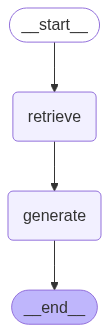

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def save_response_json(resposta_final: dict, filename: str = "resultados_rag_vw.json", modelo_rag: str = "rag"):
    """
    Gets the final response from the RAG process and saves it to a JSON file.
    
    Args:
        resposta_final (dict): The final response dictionary containing the question, context, and answer.
        filename (str): The name of the JSON file to save the results. Defaults to 'resultados_rag.json'.
        
    Returns:
        None: The function saves the response to a JSON file and does not return anything.
    """
    
    resultado = {
        "id_pergunta": f"P_{str(uuid.uuid4())[:8]}",
        "pergunta_usuario": resposta_final["question"],
        "perguntas_geradas_pelo_sistema": resposta_final.get("generated_queries", []),
        "contexto_recuperado": "\n\n".join(doc.page_content for doc in resposta_final["context"]),
        "resposta_gerada": resposta_final["answer"],
        "modelo_rag": modelo_rag,
        "metadados": {
            "marca": resposta_final.get("brand"),
            "modelo": resposta_final.get("model"),
            "ano": resposta_final.get("year")
        }
    }

    try:
        with open(filename, 'r', encoding='utf-8') as f:
            lista_resultados = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        lista_resultados = []
        
    lista_resultados.append(resultado)
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(lista_resultados, f, ensure_ascii=False, indent=4)
        
    print(f"✅ Resposta salva com sucesso em '{filename}'")

## **Questions** 

### **Volkswagen**

In [16]:
question = [
    "Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?", # 1
    "Como eu conecto meu celular Android no carro para usar os aplicativos na tela?", # 2
    "Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?", # 3
    "A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?", # 4
    "Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?", # 5
    "Como eu ajusto a hora no painel do carro?", # 6
    "Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?", # 7
    "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?", # 8
    "Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?", # 9
    "Quando é a próxima revisão do carro? É por tempo ou por quilometragem?" # 10
]

### 1 - Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?

In [17]:
response = graph.invoke({"question": question[0], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Acendeu uma luz amarela no painel com um desenho de motor (parece um '
 'motorzinho). O que pode ser e o que eu devo fazer?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
           

INFO:langchain.retrievers.multi_query:Generated queries: ['1. O que significa a luz amarela em forma de motor que acendeu no painel do meu carro e quais são os passos que devo seguir?', '   ', '2. A luz amarela com um ícone de motor no painel do veículo acendeu. Quais podem ser as causas e o que devo fazer a respeito?', '3. O que indica a luz amarela com um desenho de motor que apareceu no painel do meu carro e qual é a melhor forma de proceder?', '4. Vi uma luz amarela no painel do carro com um símbolo de motor. O que isso pode significar e quais ações eu devo tomar?', '5. A luz amarela no painel do meu carro, que parece um motorzinho, acendeu. O que isso pode indicar e qual deve ser minha reação?']


Perguntas geradas (versão de teste): ['1. O que significa a luz amarela em forma de motor que acendeu no painel do meu carro e quais são os passos que devo seguir?', '2. A luz amarela com um ícone de motor no painel do veículo acendeu. Quais podem ser as causas e o que devo fazer a respeito?', '3. O que indica a luz amarela com um desenho de motor que apareceu no painel do meu carro e qual é a melhor forma de proceder?', '4. Vi uma luz amarela no painel do carro com um símbolo de motor. O que isso pode significar e quais ações eu devo tomar?', '5. A luz amarela no painel do meu carro, que parece um motorzinho, acendeu. O que isso pode indicar e qual deve ser minha reação?']
Documentos recuperados (total único): 12
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657358748}, page_content='## Mensagem de advertência de prioridade 2  \nA luz de adv

In [18]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
A luz amarela com o desenho de um motor indica uma avaria na unidade de controle do motor (Electronic Power Control). Você deve verificar o motor imediatamente e, se necessário, procurar uma Concessionária Volkswagen. Se a luz estiver piscando, isso pode indicar um problema com o catalisador, e você deve diminuir a velocidade e dirigir com cuidado até a concessionária mais próxima. Não ignore essa luz, pois pode causar danos ao veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### 2 - Como eu conecto meu celular Android no carro para usar os aplicativos na tela?

In [19]:
response = graph.invoke({"question": question[1], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
Criando retriever base com filtro embutido: 'brand == "Volkswagen" and model == "Polo"

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Quais são os passos para emparelhar meu smartphone Android com o sistema de infotainment do carro para acessar aplicativos na tela?', '2. Como posso usar meu celular Android no carro para visualizar e controlar aplicativos na tela do veículo?', '3. Existe um guia para conectar meu dispositivo Android ao carro e utilizar os aplicativos na tela do painel?', '4. Quais métodos posso usar para integrar meu celular Android ao sistema do carro e acessar aplicativos na tela?', '5. Como faço para espelhar a tela do meu celular Android no carro e usar os aplicativos disponíveis?']


Perguntas geradas (versão de teste): ['1. Quais são os passos para emparelhar meu smartphone Android com o sistema de infotainment do carro para acessar aplicativos na tela?', '2. Como posso usar meu celular Android no carro para visualizar e controlar aplicativos na tela do veículo?', '3. Existe um guia para conectar meu dispositivo Android ao carro e utilizar os aplicativos na tela do painel?', '4. Quais métodos posso usar para integrar meu celular Android ao sistema do carro e acessar aplicativos na tela?', '5. Como faço para espelhar a tela do meu celular Android no carro e usar os aplicativos disponíveis?']
Documentos recuperados (total único): 6
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657359850}, page_content='## Estabelecer conexão  \nPara utilizar o Android Auto™ o telefone móvel precisa suportar o Android Auto™ e ser conectado 

In [20]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
Para conectar seu celular Android ao carro e usar os aplicativos na tela, siga estas etapas: 

1. Verifique se seu telefone suporta o Android Auto™ e se o aplicativo necessário está instalado.
2. Conecte o telefone ao rádio usando um cabo USB original do fabricante.
3. Siga as instruções exibidas no display do rádio e no telefone ao conectar pela primeira vez.
4. Pressione o botão APP no rádio para acessar as funções do Android Auto™.
5. Selecione seu telefone móvel pressionando o ícone correspondente na tela.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### 3 - Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?

In [21]:
response = graph.invoke({"question": question[2], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
Cria

INFO:langchain.retrievers.multi_query:Generated queries: ['Qual é a pressão ideal dos pneus para uso diário e onde posso verificar essa informação no veículo?  ', 'Como posso saber a calibragem adequada dos pneus para o dia a dia e onde essa informação está localizada no carro?  ', 'Qual deve ser a pressão correta dos pneus para o uso cotidiano e onde posso encontrar essa informação no meu carro?  ', 'Onde posso encontrar a informação sobre a calibragem dos pneus para o dia a dia e qual é a pressão recomendada?  ', 'Qual é a calibragem recomendada para pneus em uso diário e onde posso localizar essa informação no meu automóvel?']


Perguntas geradas (versão de teste): ['Qual é a pressão ideal dos pneus para uso diário e onde posso verificar essa informação no veículo?', 'Como posso saber a calibragem adequada dos pneus para o dia a dia e onde essa informação está localizada no carro?', 'Qual deve ser a pressão correta dos pneus para o uso cotidiano e onde posso encontrar essa informação no meu carro?', 'Onde posso encontrar a informação sobre a calibragem dos pneus para o dia a dia e qual é a pressão recomendada?', 'Qual é a calibragem recomendada para pneus em uso diário e onde posso localizar essa informação no meu automóvel?']
Documentos recuperados (total único): 8
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657360287}, page_content='## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros

In [22]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
A calibragem correta dos pneus pode ser encontrada na etiqueta adesiva localizada na parte interna da portinhola do tanque de combustível. Essa etiqueta fornece as pressões recomendadas para os pneus do eixo dianteiro e traseiro, além de informações sobre carregamento parcial e total. É importante verificar a pressão dos pneus quando eles estão frios, ou seja, após não terem rodado mais que alguns quilômetros nas últimas 3 horas. Calibre os pneus de acordo com os dados indicados na etiqueta e nunca exceda a pressão máxima indicada no flanco dos pneus. Lembre-se de verificar a pressão pelo menos a cada 15 dias e antes de viagens longas.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### 4 - A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?

In [23]:
response = graph.invoke({"question": question[3], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': 

INFO:langchain.retrievers.multi_query:Generated queries: ['1. O que o manual do veículo recomenda quando a luz do freio acende em vermelho e emite um sinal sonoro? É seguro dirigir nessas condições?', '2. Quais são as orientações do manual do carro para a situação em que a luz de freio está acesa em vermelho e há um alerta sonoro? Posso continuar dirigindo?', '3. A luz do freio vermelha e o apito estão ativados. O que o manual do proprietário diz sobre essa situação? É seguro seguir viagem?', '4. O que devo fazer se a luz de freio do meu carro estiver acesa em vermelho e emitindo um apito? O que o manual diz sobre isso e é seguro continuar dirigindo?', '5. Quais são as instruções do manual do carro quando a luz de freio vermelha pisca e há um alerta sonoro? É seguro continuar a condução?']


Perguntas geradas (versão de teste): ['1. O que o manual do veículo recomenda quando a luz do freio acende em vermelho e emite um sinal sonoro? É seguro dirigir nessas condições?', '2. Quais são as orientações do manual do carro para a situação em que a luz de freio está acesa em vermelho e há um alerta sonoro? Posso continuar dirigindo?', '3. A luz do freio vermelha e o apito estão ativados. O que o manual do proprietário diz sobre essa situação? É seguro seguir viagem?', '4. O que devo fazer se a luz de freio do meu carro estiver acesa em vermelho e emitindo um apito? O que o manual diz sobre isso e é seguro continuar dirigindo?', '5. Quais são as instruções do manual do carro quando a luz de freio vermelha pisca e há um alerta sonoro? É seguro continuar a condução?']
Documentos recuperados (total único): 9
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'p

In [24]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
A luz do freio acesa em vermelho e apitando indica uma situação de alerta que não deve ser ignorada. Você deve parar o veículo assim que possível em um local seguro, longe do fluxo de trânsito. Após estacionar, desligue o motor e retire a chave do cilindro da ignição. Em seguida, desembarque todos os ocupantes e leve-os para longe da estrada. Se necessário, procure auxílio técnico especializado.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### 5 - Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?

In [25]:
response = graph.invoke({"question": question[4], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[1:tasks] Starting 1 ta

INFO:langchain.retrievers.multi_query:Generated queries: ['Como funciona o sistema que desliga o motor do meu carro automaticamente no semáforo para economizar combustível? Existem situações em que eu não deveria ativá-lo?', 'Quais são os princípios de funcionamento do sistema que desliga o motor do carro quando está parado no semáforo? Há momentos em que é melhor não utilizá-lo?', 'O que é o sistema de desligamento automático do motor no meu carro e como ele contribui para a economia de combustível? Existem circunstâncias em que eu devo evitar seu uso?', 'Poderia explicar como o sistema que desliga o motor do carro em semáforos funciona? Existem condições específicas em que não é recomendado usar esse recurso?', 'Quais são as vantagens e desvantagens do sistema que desliga o motor do carro em paradas, como em semáforos? Em que situações é aconselhável não utilizá-lo?']


Perguntas geradas (versão de teste): ['Como funciona o sistema que desliga o motor do meu carro automaticamente no semáforo para economizar combustível? Existem situações em que eu não deveria ativá-lo?', 'Quais são os princípios de funcionamento do sistema que desliga o motor do carro quando está parado no semáforo? Há momentos em que é melhor não utilizá-lo?', 'O que é o sistema de desligamento automático do motor no meu carro e como ele contribui para a economia de combustível? Existem circunstâncias em que eu devo evitar seu uso?', 'Poderia explicar como o sistema que desliga o motor do carro em semáforos funciona? Existem condições específicas em que não é recomendado usar esse recurso?', 'Quais são as vantagens e desvantagens do sistema que desliga o motor do carro em paradas, como em semáforos? Em que situações é aconselhável não utilizá-lo?']
Documentos recuperados (total único): 10
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'source':

In [26]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
O sistema Start-Stop desliga automaticamente o motor ao parar o veículo e o religa quando necessário, como ao retirar o pé do pedal do freio. Para usar, basta pisar no pedal do freio e mantê-lo pressionado até a parada, e o motor se desligará. Para reiniciar, retire o pé do freio ou pise no acelerador. É importante não usar o sistema em água, pois isso pode danificar o motor, e em trechos alagados, o sistema deve ser desativado manualmente. Além disso, certifique-se de que todas as condições para o desligamento automático estejam atendidas, como cinto de segurança afivelado e porta do condutor fechada.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### 6 - Como eu ajusto a hora no painel do carro?

In [27]:
response = graph.invoke({"question": question[5], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
Criando retriever base com filtro embutido: 'brand == "Volkswagen" and model == "Polo" and year == "2025"'
Invocando o MultiQueryRetriever dinâmico...


INFO:langchain.retrievers.multi_query:Generated queries: ['Como posso alterar a hora no relógio do painel do meu carro?  ', 'Quais são os passos para configurar a hora no painel do veículo?  ', 'Como faço para ajustar o horário no display do carro?  ', 'O que devo fazer para corrigir a hora no painel do meu automóvel?  ', 'Como redefinir a hora no relógio do painel do carro?']


Perguntas geradas (versão de teste): ['Como posso alterar a hora no relógio do painel do meu carro?', 'Quais são os passos para configurar a hora no painel do veículo?', 'Como faço para ajustar o horário no display do carro?', 'O que devo fazer para corrigir a hora no painel do meu automóvel?', 'Como redefinir a hora no relógio do painel do carro?']
Documentos recuperados (total único): 6
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657358760}, page_content='## Ajustar o horário através do sistema de rádio  \nDependendo da versão do veículo e da versão do rádio.  \n<!-- image -->  \n- -Pressionar o botão do rádio  .\n- -Tocar na superfície de função  para abrir o menu Configurações do veículo .\n- -Selecionar o item de menu Hora e data para ajustar o horário → Página 32.\n- -OU\n- -Pressionar o botão configurações  .\n- -Tocar na superfície 

In [28]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
Para ajustar a hora no painel do carro, você pode usar o sistema de rádio ou o instrumento combinado. 

**Pelo rádio:**
1. Pressione o botão do rádio.
2. Toque na superfície de função para abrir o menu Configurações do veículo.
3. Selecione o item de menu Hora e data para ajustar o horário.

**Pelo instrumento combinado digital:**
1. No menu Dados de viagem, selecione o indicador Autonomia.
2. Mantenha pressionado o botão OK no volante multifunções por cerca de cinco segundos.
3. Selecione o menu Hora e ajuste o relógio com os botões de seta. 

**Pelo instrumento combinado analógico:**
1. Ligue a ignição.
2. Pressione o botão no instrumento combinado para selecionar o indicador das horas.
3. Ajuste as horas e minutos pressionando brevemente o botão correspondente e finalize pressionando novamente o botão.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### 7 - Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?

In [29]:
response = graph.invoke({"question": question[6], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
Criando retriever base com filtr

INFO:langchain.retrievers.multi_query:Generated queries: ['Se eu tiver um pneu furado, onde posso encontrar o macaco e as ferramentas para a troca? E qual é o procedimento para trocar o pneu?', 'Onde estão localizados o macaco e as ferramentas para trocar um pneu furado? Como posso realizar a troca do pneu?', 'Caso eu fure um pneu, onde posso achar o macaco e as ferramentas necessárias? Qual é o passo a passo para trocar o pneu?', 'Se o pneu do meu carro furar, onde estão o macaco e as ferramentas para a troca? Como eu posso fazer essa troca corretamente?', 'O que devo fazer se furar um pneu? Onde posso encontrar o macaco e as ferramentas, e como é o processo de troca?']


Perguntas geradas (versão de teste): ['Se eu tiver um pneu furado, onde posso encontrar o macaco e as ferramentas para a troca? E qual é o procedimento para trocar o pneu?', 'Onde estão localizados o macaco e as ferramentas para trocar um pneu furado? Como posso realizar a troca do pneu?', 'Caso eu fure um pneu, onde posso achar o macaco e as ferramentas necessárias? Qual é o passo a passo para trocar o pneu?', 'Se o pneu do meu carro furar, onde estão o macaco e as ferramentas para a troca? Como eu posso fazer essa troca corretamente?', 'O que devo fazer se furar um pneu? Onde posso encontrar o macaco e as ferramentas, e como é o processo de troca?']
Documentos recuperados (total único): 6
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657360367}, page_content='- 6. Soltar os parafusos da roda a ser trocada → Página 267.\n- 7. Procurar sob o 

In [30]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
O macaco e as ferramentas para trocar o pneu estão localizados no compartimento de bagagem. Para trocar o pneu, siga estes passos: primeiro, solte os parafusos da roda a ser trocada. Em seguida, procure sob o veículo o ponto de apoio do macaco, mais próximo da roda a ser trocada, e insira a chave de roda no olhal do macaco. Levante o macaco até que a roda se eleve do chão, remova os parafusos e a roda danificada, coloque a roda de emergência, e aperte os parafusos firmemente, alternando entre os opostos. Após a troca, abaixe o veículo e verifique o torque dos parafusos com um torquímetro.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### 8 - O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?

In [31]:
response = graph.invoke({"question": question[7], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a difer

INFO:langchain.retrievers.multi_query:Generated queries: ["Quais são as principais diferenças entre os modos de condução 'Eco' e 'Sport' em um carro, e como posso escolher entre eles?", "Como funciona o modo de condução 'Eco' em comparação com o modo 'Sport' em veículos, e qual é a melhor forma de selecionar um deles?", "O que distingue os modos de condução 'Eco' e 'Sport' em um carro, e quais são os critérios para a seleção de um modo?", "Pode explicar as diferenças entre os modos 'Eco' e 'Sport' em um carro e como eu posso alternar entre esses modos?", "Quais características dos modos de condução 'Eco' e 'Sport' devem ser consideradas ao escolher entre eles em um veículo?"]


Perguntas geradas (versão de teste): ["Quais são as principais diferenças entre os modos de condução 'Eco' e 'Sport' em um carro, e como posso escolher entre eles?", "Como funciona o modo de condução 'Eco' em comparação com o modo 'Sport' em veículos, e qual é a melhor forma de selecionar um deles?", "O que distingue os modos de condução 'Eco' e 'Sport' em um carro, e quais são os critérios para a seleção de um modo?", "Pode explicar as diferenças entre os modos 'Eco' e 'Sport' em um carro e como eu posso alternar entre esses modos?", "Quais características dos modos de condução 'Eco' e 'Sport' devem ser consideradas ao escolher entre eles em um veículo?"]
Documentos recuperados (total único): 5
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657359405}, page_content='## Características dos perfis de condução  \n<!-- image -->  \nEco : coloca o

In [32]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
O modo 'Eco' prioriza a economia de combustível, colocando o veículo em um estado de baixo consumo e ativando a função de roda-livre. Já o modo 'Sport' proporciona uma experiência de condução mais esportiva, alterando o som do motor e mudando automaticamente a alavanca seletora para a posição S. Para selecionar entre os modos, mova a alavanca seletora para trás para alternar entre as posições D e S. A alavanca sempre retornará elasticamente à posição D/S. O modo 'Normal' oferece uma configuração equilibrada para o uso diário.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### 9 - Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?

In [33]:
response = graph.invoke({"question": question[8], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no man

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Meu carro Polo é capaz de rebocar um trailer pequeno? Existem orientações específicas no manual que eu deva seguir?', '2. É possível usar meu Polo para puxar um reboque pequeno? O que o manual do veículo recomenda sobre isso?', '3. Quais são as capacidades do meu Polo em relação ao reboque de um trailer pequeno? O manual menciona alguma instrução importante?', '4. Meu Volkswagen Polo pode rebocar um pequeno reboque? Há alguma recomendação no manual que eu precise considerar?', '5. Estou pensando em rebocar um reboque pequeno com meu Polo. O que o manual do carro diz sobre essa prática?']


Perguntas geradas (versão de teste): ['1. Meu carro Polo é capaz de rebocar um trailer pequeno? Existem orientações específicas no manual que eu deva seguir?', '2. É possível usar meu Polo para puxar um reboque pequeno? O que o manual do veículo recomenda sobre isso?', '3. Quais são as capacidades do meu Polo em relação ao reboque de um trailer pequeno? O manual menciona alguma instrução importante?', '4. Meu Volkswagen Polo pode rebocar um pequeno reboque? Há alguma recomendação no manual que eu precise considerar?', '5. Estou pensando em rebocar um reboque pequeno com meu Polo. O que o manual do carro diz sobre essa prática?']
Documentos recuperados (total único): 9
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657359929}, page_content='##  Introdução ao tema  \nObservar as prescrições específicas dos países para a condução com um reboque e

In [34]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
Sim, o seu Polo pode puxar um reboque pequeno, desde que esteja equipado com um dispositivo de reboque adequado. É importante que o dispositivo de reboque seja fixado nos pontos de fixação visíveis na parte inferior do veículo, conforme ilustrado na figura mencionada. Utilize apenas um dispositivo liberado para o peso bruto admissível do reboque. Além disso, conduza com cautela, ajustando a velocidade e a forma de frenagem, especialmente em declives. Para mais informações sobre a instalação do dispositivo, consulte uma Concessionária Volkswagen.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### 10 - Quando é a próxima revisão do carro? É por tempo ou por quilometragem?

In [35]:
response = graph.invoke({"question": question[9], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
Criando retriever base com filtro embutido: 'brand == "Volkswagen" and model == "Polo" and year == "2025"'
Invocando o

INFO:langchain.retrievers.multi_query:Generated queries: ['Quando será a próxima manutenção do meu carro? É baseada em tempo ou na quilometragem?', 'Qual é a data da próxima revisão do veículo? A periodicidade é determinada por tempo ou por distância?', 'Quando devo levar meu carro para a próxima revisão? Isso é definido por um intervalo de tempo ou pela quilometragem?', 'Qual é o próximo agendamento de revisão do carro? A frequência é estabelecida por tempo ou por quilometragem?', 'Quando é a próxima inspeção do meu carro? É programada com base em meses ou em milhas rodadas?']


Perguntas geradas (versão de teste): ['Quando será a próxima manutenção do meu carro? É baseada em tempo ou na quilometragem?', 'Qual é a data da próxima revisão do veículo? A periodicidade é determinada por tempo ou por distância?', 'Quando devo levar meu carro para a próxima revisão? Isso é definido por um intervalo de tempo ou pela quilometragem?', 'Qual é o próximo agendamento de revisão do carro? A frequência é estabelecida por tempo ou por quilometragem?', 'Quando é a próxima inspeção do meu carro? É programada com base em meses ou em milhas rodadas?']
Documentos recuperados (total único): 5
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657358774}, page_content='## Aviso de serviço  \nQuando um serviço estiver próximo a vencer, aparecerá um aviso de serviço ao ligar a ignição.  \nA quilometragem ou o tempo especificado correspondem a qu

In [36]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_vw.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
A próxima revisão do carro deve ser realizada a cada 10.000 km ou 12 meses, prevalecendo o que ocorrer primeiro. O aviso de serviço aparecerá ao ligar a ignição quando estiver próximo do vencimento. É importante seguir rigorosamente os prazos de verificação e substituição estipulados. Caso necessário, a Concessionária Volkswagen informará sobre a necessidade de substituição de peças durante as verificações. Manutenção insuficiente pode resultar na perda da garantia do veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_vw.json'


### **Fiat**

In [37]:
question = [
    "Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?", # 1
    "A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?", # 2
    "Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?", # 3
    "A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?", # 4
    "Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?", # 5
    "As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?", # 6
    "Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?", # 7
    "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?", # 8
    "Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?", # 9
    "Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?" # 10
]

### 1- Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?

In [38]:
response = graph.invoke({"question": question[0], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Onde posso encontrar o estepe, o macaco e as ferramentas necessárias para trocar um pneu furado na estrada, e quais são os passos para realizar essa troca de forma segura?', '2. Quais são os locais onde estão armazenados o estepe, o macaco e as ferramentas no meu carro, e como posso trocar o pneu furado com segurança?', '3. Como posso localizar o estepe, o macaco e as ferramentas no meu veículo, e quais são as instruções principais para trocar um pneu furado na estrada?', '4. Poderia me informar onde estão o estepe, o macaco e as ferramentas no carro, além dos passos essenciais para trocar um pneu furado de maneira segura?', '5. Quais são os passos para trocar um pneu furado na estrada, e onde posso encontrar o estepe, o macaco e as ferramentas necessárias para isso?']


Perguntas geradas (versão de teste): ['1. Onde posso encontrar o estepe, o macaco e as ferramentas necessárias para trocar um pneu furado na estrada, e quais são os passos para realizar essa troca de forma segura?', '2. Quais são os locais onde estão armazenados o estepe, o macaco e as ferramentas no meu carro, e como posso trocar o pneu furado com segurança?', '3. Como posso localizar o estepe, o macaco e as ferramentas no meu veículo, e quais são as instruções principais para trocar um pneu furado na estrada?', '4. Poderia me informar onde estão o estepe, o macaco e as ferramentas no carro, além dos passos essenciais para trocar um pneu furado de maneira segura?', '5. Quais são os passos para trocar um pneu furado na estrada, e onde posso encontrar o estepe, o macaco e as ferramentas necessárias para isso?']
Documentos recuperados (total único): 6
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Ar

In [39]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
O estepe, o macaco e as ferramentas estão localizados no porta-ferramentas B, sob a roda sobressalente. Para trocar o pneu, siga estes passos: 

1. Estacione o veículo em um local seguro, longe da borda da pista, e ligue as luzes de emergência.
2. Alivie os parafusos da roda furada com a chave de roda, girando no sentido anti-horário, enquanto a roda ainda estiver no chão.
3. Coloque calços na roda oposta e, em seguida, use o macaco para levantar o veículo.
4. Remova a roda furada, coloque o estepe e aperte os parafusos, alternando entre eles.
5. Baixe o veículo e, por fim, guarde o macaco e as ferramentas no porta-ferramentas.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'


### 2 - A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?

In [40]:
response = graph.invoke({"question": question[1], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fi

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Como posso usar uma bateria auxiliar de outro carro para dar partida no meu veículo que não está ligando devido à bateria descarregada, sem causar danos?', '2. Quais são os passos corretos para conectar uma bateria auxiliar a um carro com a bateria descarregada, garantindo que nada seja danificado?', '3. O que devo fazer para realizar a partida do meu carro com uma bateria descarregada utilizando a chupeta de outro veículo, evitando qualquer tipo de problema?', '4. Existe um procedimento seguro para dar partida em um carro com a bateria descarregada usando a bateria de outro carro, sem arriscar danificar os sistemas elétricos?', '5. Quais cuidados devo ter ao usar uma bateria auxiliar de outro carro para ligar o meu veículo que não está funcionando por causa da bateria descarregada?']


Perguntas geradas (versão de teste): ['1. Como posso usar uma bateria auxiliar de outro carro para dar partida no meu veículo que não está ligando devido à bateria descarregada, sem causar danos?', '2. Quais são os passos corretos para conectar uma bateria auxiliar a um carro com a bateria descarregada, garantindo que nada seja danificado?', '3. O que devo fazer para realizar a partida do meu carro com uma bateria descarregada utilizando a chupeta de outro veículo, evitando qualquer tipo de problema?', '4. Existe um procedimento seguro para dar partida em um carro com a bateria descarregada usando a bateria de outro carro, sem arriscar danificar os sistemas elétricos?', '5. Quais cuidados devo ter ao usar uma bateria auxiliar de outro carro para ligar o meu veículo que não está funcionando por causa da bateria descarregada?']
Documentos recuperados (total único): 9
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', '

In [41]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
Para fazer a partida com uma bateria auxiliar, siga estes passos: 

1. Conecte uma extremidade do cabo positivo (+) ao terminal positivo (+) da bateria descarregada.
2. Conecte a outra extremidade do cabo positivo (+) ao terminal positivo (+) da bateria auxiliar.
3. Conecte uma extremidade do cabo negativo (-) ao terminal negativo (-) da bateria auxiliar.
4. Conecte a outra extremidade do cabo negativo (-) a uma parte metálica do motor ou da caixa de câmbio do veículo com a bateria descarregada, longe da bateria e do sistema de injeção de combustível.
5. Ligue o motor do veículo com a bateria auxiliar e, após alguns minutos, ligue o motor do veículo com a bateria descarregada. 

Lembre-se de não conectar os terminais negativos das duas baterias diretamente.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'


### 3 - Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?

In [42]:
response = graph.invoke({"question": question[2], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
Criando retriever base com filtro embuti

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Quais são os métodos para descobrir a pressão ideal dos pneus do meu veículo e onde posso encontrar essa informação?', '2. Onde posso verificar a pressão adequada dos pneus do meu carro e quais são as fontes confiáveis para essa informação?', '3. Como posso determinar a pressão correta dos pneus do meu automóvel e onde está disponível essa informação?', '4. Quais são os passos para saber a pressão correta dos pneus do meu carro e onde posso localizar esses dados?', '5. Onde posso encontrar informações sobre a pressão recomendada para os pneus do meu carro e como posso confirmar essa informação?']


Perguntas geradas (versão de teste): ['1. Quais são os métodos para descobrir a pressão ideal dos pneus do meu veículo e onde posso encontrar essa informação?', '2. Onde posso verificar a pressão adequada dos pneus do meu carro e quais são as fontes confiáveis para essa informação?', '3. Como posso determinar a pressão correta dos pneus do meu automóvel e onde está disponível essa informação?', '4. Quais são os passos para saber a pressão correta dos pneus do meu carro e onde posso localizar esses dados?', '5. Onde posso encontrar informações sobre a pressão recomendada para os pneus do meu carro e como posso confirmar essa informação?']
Documentos recuperados (total único): 7
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032130}, page_content="## Nota  \nPor realizar uma checagem indireta da pressão dos pneus através da central de freio, o sistema nã

In [43]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
A pressão correta para os pneus do seu carro pode ser encontrada no capítulo "Dados técnicos", especificamente na seção "Rodas e Pneus". É importante verificar a pressão dos pneus a frio, ou seja, antes de dirigir o veículo. Caso a luz-espia acenda, isso indica que a pressão de um ou mais pneus está abaixo do recomendado. Após ajustar a pressão, você deve realizar o reset do sistema através do quadro de instrumentos para garantir que as informações sejam precisas. Verifique também a pressão do pneu sobressalente, seguindo as mesmas orientações.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'


### 4 - A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?

In [44]:
response = graph.invoke({"question": question[3], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
Criando retriever base com filtro embutido: 'brand == "Fiat" and model == "Argo"

INFO:langchain.retrievers.multi_query:Generated queries: ['1. O que significa quando a luz de temperatura do motor acende e há vapor saindo do capô do carro?  ', '2. Quais são os passos que devo seguir se a luz de temperatura do motor acender e vapor estiver saindo do capô?  ', '3. O que pode causar a luz de temperatura do motor a acender e vapor saindo do capô?  ', '4. Como devo reagir se notar vapor saindo do capô e a luz de temperatura do motor acesa?  ', '5. Quais são os riscos e as ações recomendadas quando a luz de temperatura do motor acende e vapor é visível no capô?']


Perguntas geradas (versão de teste): ['1. O que significa quando a luz de temperatura do motor acende e há vapor saindo do capô do carro?', '2. Quais são os passos que devo seguir se a luz de temperatura do motor acender e vapor estiver saindo do capô?', '3. O que pode causar a luz de temperatura do motor a acender e vapor saindo do capô?', '4. Como devo reagir se notar vapor saindo do capô e a luz de temperatura do motor acesa?', '5. Quais são os riscos e as ações recomendadas quando a luz de temperatura do motor acende e vapor é visível no capô?']
Documentos recuperados (total único): 8
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032650}, page_content='## SISTEMA DE ARREFECIMENTO  \nA saída de líquido de arrefecimento do motor ou de vapor do radiador pode provocar queimaduras graves.  \nSe notar vapor proveniente do vão do motor, não abrir o capô 

In [45]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
Se a luz de temperatura do motor acendeu e está saindo vapor do capô, pare o veículo imediatamente e desligue o motor. Não abra o capô até que o radiador tenha arrefecido para evitar queimaduras. Após o motor esfriar, verifique o nível do líquido de arrefecimento no reservatório, que deve estar entre as referências MIN e MAX. Se necessário, abra lentamente o tampão do reservatório e reponha o líquido. Lembre-se de que a saída de vapor pode ser normal em condições de umidade, mas é importante verificar a situação.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'


### 5 - Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?

In [46]:
response = graph.invoke({"question": question[4], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu car

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Meu carro parou de funcionar depois de passar por um buraco. Isso pode ter ativado alguma proteção do motor? O que devo fazer agora?', '2. Após passar por um buraco, meu carro não liga mais. Existe a possibilidade de ter acionado uma trava de segurança? Quais são os próximos passos que eu posso tomar?', '3. O que pode ter acontecido com meu carro que parou de funcionar após eu passar por um buraco? É possível que uma trava de segurança do motor tenha sido ativada? Como posso resolver isso?', '4. Meu veículo não está ligando depois de ter passado por um buraco. Isso pode ser causado por uma ativação de segurança do motor? Que medidas eu posso tomar para consertar a situação?', '5. Depois de passar por um buraco, meu carro não liga. Será que alguma proteção do motor foi acionada? O que eu deveria fazer para tentar resolver esse problema?']


Perguntas geradas (versão de teste): ['1. Meu carro parou de funcionar depois de passar por um buraco. Isso pode ter ativado alguma proteção do motor? O que devo fazer agora?', '2. Após passar por um buraco, meu carro não liga mais. Existe a possibilidade de ter acionado uma trava de segurança? Quais são os próximos passos que eu posso tomar?', '3. O que pode ter acontecido com meu carro que parou de funcionar após eu passar por um buraco? É possível que uma trava de segurança do motor tenha sido ativada? Como posso resolver isso?', '4. Meu veículo não está ligando depois de ter passado por um buraco. Isso pode ser causado por uma ativação de segurança do motor? Que medidas eu posso tomar para consertar a situação?', '5. Depois de passar por um buraco, meu carro não liga. Será que alguma proteção do motor foi acionada? O que eu deveria fazer para tentar resolver esse problema?']
Documentos recuperados (total único): 14
[1:writes] Finished step 1 with writes to 2 channels:
- context -> 

In [47]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
Se o seu carro não liga após passar por um buraco, pode ser que o sistema de proteção e bloqueio do motor tenha sido ativado. Primeiro, gire a chave para a posição MAR e verifique se a luz-espia acende. Se acender, isso indica que o código da chave não foi reconhecido; nesse caso, retorne a chave para a posição STOP e tente novamente. Se o problema persistir, experimente usar as outras chaves fornecidas. Se ainda assim não funcionar, pode ser necessário consultar a Rede Assistencial Fiat.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'


### 6 - As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?

In [48]:
response = graph.invoke({"question": question[5], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luz

INFO:langchain.retrievers.multi_query:Generated queries: ['1. O que significa quando as luzes do ABS e do freio (vermelha com um ponto de exclamação) acendem simultaneamente no painel do Argo? É seguro dirigir nessas condições?', '2. Quais são os riscos de continuar dirigindo um Argo com as luzes do ABS e do freio acesas no painel?', '3. Se as luzes do ABS e do freio (vermelha com um ponto de exclamação) estão acesas no painel do meu Argo, quais medidas devo tomar?', '4. É perigoso dirigir um Argo quando as luzes do ABS e do freio acendem juntas? Quais são as implicações disso?', '5. O que devo fazer se as luzes do ABS e do freio (com ponto de exclamação) acenderem ao mesmo tempo no painel do meu carro?']


Perguntas geradas (versão de teste): ['1. O que significa quando as luzes do ABS e do freio (vermelha com um ponto de exclamação) acendem simultaneamente no painel do Argo? É seguro dirigir nessas condições?', '2. Quais são os riscos de continuar dirigindo um Argo com as luzes do ABS e do freio acesas no painel?', '3. Se as luzes do ABS e do freio (vermelha com um ponto de exclamação) estão acesas no painel do meu Argo, quais medidas devo tomar?', '4. É perigoso dirigir um Argo quando as luzes do ABS e do freio acendem juntas? Quais são as implicações disso?', '5. O que devo fazer se as luzes do ABS e do freio (com ponto de exclamação) acenderem ao mesmo tempo no painel do meu carro?']
Documentos recuperados (total único): 11
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926031993}, page_content='| AVARIA EBD O acendimento simultâneo das luzes-espia (ver

In [49]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
Sim, é perigoso continuar dirigindo com as luzes do ABS e do freio acesas simultaneamente. Isso indica uma avaria no sistema EBD ou que o sistema ABS não está disponível, o que pode resultar em travamento precoce das rodas traseiras e derrapagens. É recomendado dirigir com extrema prudência e se dirigir imediatamente à Rede Assistencial Fiat para verificação do sistema. Não ignore essa situação, pois pode comprometer a segurança do veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'


### 7 - Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?

In [50]:
response = graph.invoke({"question": question[6], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
Criando retriever base com filtro embutido: 'brand == "Fiat"

INFO:langchain.retrievers.multi_query:Generated queries: ['1. O que acontece com o sistema de travamento das portas se eu deixar a chave dentro do carro?', '2. Como o carro reage ao tentar trancar as portas quando a chave está dentro?', '3. Se a chave estiver dentro do veículo, o que ocorre ao tentar fechar as portas?', '4. Quais são as consequências de tentar trancar o carro com a chave ainda dentro dele?', '5. O que o sistema de segurança do carro faz se eu esquecer a chave dentro e tentar trancar?']


Perguntas geradas (versão de teste): ['1. O que acontece com o sistema de travamento das portas se eu deixar a chave dentro do carro?', '2. Como o carro reage ao tentar trancar as portas quando a chave está dentro?', '3. Se a chave estiver dentro do veículo, o que ocorre ao tentar fechar as portas?', '4. Quais são as consequências de tentar trancar o carro com a chave ainda dentro dele?', '5. O que o sistema de segurança do carro faz se eu esquecer a chave dentro e tentar trancar?']
Documentos recuperados (total único): 10
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926031653}, page_content='Para acionar o travamento das portas, apertar o botão . As portas se travam e a luz interna se apaga. Os indicadores de direção efetuam uma sinalização luminosa simples e ocorre a sinalização sonora (quando disponível o alarme).  \nDurante o travamento das portas d

In [51]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
Se a chave eletrônica for esquecida dentro do veículo equipado com o "Passive Entry", o sistema não permitirá o travamento das portas ao pressionar o botão de travamento. As portas não trancarão se uma chave eletrônica for detectada no interior do veículo e nenhuma outra chave eletrônica habilitada estiver presente no exterior. Para reativar o funcionamento correto, pressione o botão no telecomando. Caso a chave esteja no porta-malas e você tente fechá-lo, o travamento não será efetuado a menos que uma outra chave eletrônica reconhecida esteja próxima.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'


### 8 - Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?

In [52]:
response = graph.invoke({"question": question[7], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 

INFO:langchain.retrievers.multi_query:Generated queries: ["1. O que significa o aviso 'HCSS' que aparece no meu carro antes de dar a partida, especialmente em dias frios? É algo comum?", "2. A luz de aviso em forma de 'mola' que aparece no meu carro antes de ligar é normal? Como devo proceder quando isso acontece?", "3. Meu carro apresenta um alerta de 'HCSS' e uma luzinha de 'mola' antes de dar a partida em temperaturas frias. Isso é um problema? O que devo fazer?", "4. É normal que meu carro mostre um aviso de 'HCSS' ou uma luz de 'mola' antes de ligar, especialmente quando está frio? Quais são as recomendações?", "5. O que devo saber sobre o aviso 'HCSS' e a luzinha de 'mola' que aparecem no meu carro antes da partida em clima frio? É algo que deve me preocupar?"]


Perguntas geradas (versão de teste): ["1. O que significa o aviso 'HCSS' que aparece no meu carro antes de dar a partida, especialmente em dias frios? É algo comum?", "2. A luz de aviso em forma de 'mola' que aparece no meu carro antes de ligar é normal? Como devo proceder quando isso acontece?", "3. Meu carro apresenta um alerta de 'HCSS' e uma luzinha de 'mola' antes de dar a partida em temperaturas frias. Isso é um problema? O que devo fazer?", "4. É normal que meu carro mostre um aviso de 'HCSS' ou uma luz de 'mola' antes de ligar, especialmente quando está frio? Quais são as recomendações?", "5. O que devo saber sobre o aviso 'HCSS' e a luzinha de 'mola' que aparecem no meu carro antes da partida em clima frio? É algo que deve me preocupar?"]
Documentos recuperados (total único): 11
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032046}, page_cont

In [53]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
O aviso de 'HCSS' e a luz-espia que acende antes de dar a partida são normais em temperaturas abaixo de 30°C, especialmente se o veículo estiver utilizando etanol ou uma mistura de etanol/gasolina. Você deve aguardar até que a luz-espia se apague antes de tentar dar a partida no motor. Se a luz-espia lampejar de forma intermitente, isso indica que o sistema HCSS está indisponível, e você deve procurar a Rede Assistencial Fiat. Caso a luz-espia permaneça acesa após a partida, isso pode indicar um mau funcionamento no sistema de controle do motor. Siga sempre as instruções do manual para garantir o funcionamento adequado do veículo.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'


### 9 - Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?

In [54]:
response = graph.invoke({"question": question[8], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
Criando retriever base com filtro embutido: 'brand == "Fiat" and model == "Argo" and year == "2023"'
Invocando o Multi

INFO:langchain.retrievers.multi_query:Generated queries: ['1. Qual é a capacidade total do tanque de combustível do carro, considerando a reserva?', '2. Quantos litros de combustível o tanque do meu carro pode armazenar, incluindo a parte da reserva?', '3. Qual é o volume total de combustível que o tanque do carro comporta, levando em conta a reserva?', '4. Qual é a quantidade máxima de litros de combustível que o tanque do carro, incluindo a reserva, pode conter?', '5. Qual é a capacidade do tanque de combustível do veículo, se incluirmos a reserva?']


Perguntas geradas (versão de teste): ['1. Qual é a capacidade total do tanque de combustível do carro, considerando a reserva?', '2. Quantos litros de combustível o tanque do meu carro pode armazenar, incluindo a parte da reserva?', '3. Qual é o volume total de combustível que o tanque do carro comporta, levando em conta a reserva?', '4. Qual é a quantidade máxima de litros de combustível que o tanque do carro, incluindo a reserva, pode conter?', '5. Qual é a capacidade do tanque de combustível do veículo, se incluirmos a reserva?']
Documentos recuperados (total único): 7
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032776}, page_content='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|

In [55]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
O tanque de combustível do carro tem uma capacidade total de 47 litros. A reserva de combustível varia entre 5,5 a 7,5 litros. Portanto, a capacidade total do tanque, incluindo a reserva, é de 52,5 a 54,5 litros.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'


### 10 - Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?

In [56]:
response = graph.invoke({"question": question[9], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["answer"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando '
 'troco o filtro junto?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- retrieve -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
Criando retriever base com f

INFO:langchain.retrievers.multi_query:Generated queries: ['Qual é a quantidade de óleo necessária para o motor 1.0 Flex do Argo, incluindo a troca do filtro?  ', 'Qual é a capacidade total de óleo do motor 1.0 Flex do Argo ao realizar a troca do filtro?  ', 'Quando faço a troca do filtro, quanto óleo deve ser adicionado ao motor 1.0 Flex do Argo?  ', 'Qual é o volume de óleo recomendado para o motor 1.0 Flex do Argo, considerando a troca do filtro?  ', 'Para o Argo com motor 1.0 Flex, qual é a capacidade de óleo ao trocar o filtro de óleo?']


Perguntas geradas (versão de teste): ['Qual é a quantidade de óleo necessária para o motor 1.0 Flex do Argo, incluindo a troca do filtro?', 'Qual é a capacidade total de óleo do motor 1.0 Flex do Argo ao realizar a troca do filtro?', 'Quando faço a troca do filtro, quanto óleo deve ser adicionado ao motor 1.0 Flex do Argo?', 'Qual é o volume de óleo recomendado para o motor 1.0 Flex do Argo, considerando a troca do filtro?', 'Para o Argo com motor 1.0 Flex, qual é a capacidade de óleo ao trocar o filtro de óleo?']
Documentos recuperados (total único): 7
[1:writes] Finished step 1 with writes to 2 channels:
- context -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032770}, page_content='## Especificações  \n| Pesos (kg)                                                                                         | ARGO 1.0 Flex   | ARGO DRIVE 1.0 Flex   | ARGO DRIVE 1.3 Flex CVT   | ARGO TREKKING 1.3 Flex   | ARGO TREKKING

In [57]:
print("\n--- Resposta gerada ---")
print(response["answer"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_rag_multiquery_fiat.json", modelo_rag="rag_multiquery")


--- Resposta gerada ---
A capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando trocando o filtro, é de 5,50 a 7,50 litros. Para realizar a troca do filtro do óleo, utilize uma peça genuína específica para o veículo. A substituição do filtro deve ser feita sempre que o óleo do motor for trocado. Certifique-se de seguir os intervalos de manutenção recomendados no 'Plano de Manutenção programada'. Não sei, não tenho essa informação sobre a localização exata do filtro.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_rag_multiquery_fiat.json'
